# 0.0 Imports

In [90]:
import pandas as pd
import seaborn as sns
import inflection

from collections             import Counter
from IPython.display         import Image
from matplotlib              import pyplot as plt
from IPython.core.display    import HTML

from sklearn.model_selection import train_test_split

## 0.1 Helper Functions

In [147]:
def notebook_setting():

    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    #plt.rcParams['figure.figsize'] = [14, 5]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

notebook_setting()
    

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Data

In [2]:
df_raw = pd.read_csv('../data/raw/train.csv')

In [3]:
df_raw.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

## 0.3 Train & Test Split

In [4]:
# define X and y
X = df_raw.iloc[:, :-1]
y = df_raw.iloc[:, -1:]

# split x and y
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1)

# concat train data
df = pd.concat([X_train, y_train], axis=1)

# 1.0 Data Description

## 1.1 Data Dimensions

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342998 entries, 180394 to 258454
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    342998 non-null  int64  
 1   Gender                342998 non-null  object 
 2   Age                   342998 non-null  int64  
 3   Driving_License       342998 non-null  int64  
 4   Region_Code           342998 non-null  float64
 5   Previously_Insured    342998 non-null  int64  
 6   Vehicle_Age           342998 non-null  object 
 7   Vehicle_Damage        342998 non-null  object 
 8   Annual_Premium        342998 non-null  float64
 9   Policy_Sales_Channel  342998 non-null  float64
 10  Vintage               342998 non-null  int64  
 11  Response              342998 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.0+ MB


In [37]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
180394,180395,Male,23,1,41.0,1,< 1 Year,Yes,39640.0,152.0,213,0
98482,98483,Male,27,1,3.0,0,< 1 Year,Yes,39788.0,154.0,244,0
237256,237257,Female,30,1,15.0,0,< 1 Year,Yes,32331.0,124.0,258,1
158770,158771,Female,21,1,2.0,1,< 1 Year,No,34263.0,160.0,252,0
120041,120042,Male,29,1,28.0,0,< 1 Year,No,2630.0,152.0,40,0


## 1.2 Descriptive Statistics

### Numerical

In [47]:
desc = df[['Age', 'Annual_Premium', 'Vintage']]
ds2 = desc.describe().T
ds = pd.DataFrame(desc.skew())
ds1 = pd.DataFrame(desc.kurtosis())
stats = pd.concat([ds2, ds, ds1], axis=1)
stats.columns = ['count', 'mean','std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis']
stats

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Age,342998.0,38.824442,15.508076,20.0,25.0,36.0,49.0,85.0,0.672572,-0.565081
Annual_Premium,342998.0,30571.575756,17232.268633,2630.0,24408.0,31671.5,39404.0,540165.0,1.826373,35.744521
Vintage,342998.0,154.380655,83.659011,10.0,82.0,154.0,227.0,299.0,0.002283,-1.200325


### Categorical

In [52]:
catt = df[['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured',
            'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']]
catt.apply( lambda x: x.unique().shape[0])

Gender                    2
Driving_License           2
Region_Code              53
Previously_Insured        2
Vehicle_Age               3
Vehicle_Damage            2
Policy_Sales_Channel    155
dtype: int64

# 2.0 Feature Engineering

In [74]:
df1 = df.copy()

## 2.1 Rename Columns

In [75]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']
snake_case = lambda x: inflection.underscore(x)
cols_new = list(map(snake_case, cols_old))

# Rename
df1.columns = cols_new

## 2.2 Feature Engineering

In [76]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
7647,7648,Female,37,1,46.0,0,1-2 Year,Yes,29336.0,124.0,286,1
297373,297374,Female,23,1,8.0,1,< 1 Year,No,27611.0,152.0,190,0
114745,114746,Male,54,1,28.0,0,1-2 Year,Yes,28474.0,26.0,132,0
343451,343452,Female,79,1,28.0,0,1-2 Year,Yes,46970.0,26.0,188,0
272987,272988,Female,49,1,46.0,1,1-2 Year,No,17486.0,124.0,50,0


### Average Annual Premium by Region code

In [77]:
# Average Annual premium per region code
aux1 = df1[['region_code', 'annual_premium']].groupby('region_code').mean().reset_index()

# Merge with the original dataset
aux1.rename(columns={'annual_premium': 'mean_premium_by_code'}, inplace=True)
df1 = pd.merge(df1, aux1, on='region_code', how='left')

### Insurance by Region Code

In [78]:
# Insured by code
df10 = df1[df1['previously_insured'] == 1 ]
aux1 = df10[['previously_insured', 'region_code']].groupby('region_code').count().reset_index()


# Merge with the original dataset
aux1.rename(columns={'previously_insured': 'previously_insured_by_code'}, inplace=True)
df1 = pd.merge(df1, aux1, on='region_code', how='left')

### Features Changes

In [79]:
# Vahicle Damage
df1['vehicle_damage'] = df1['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vahicle Age
df1['vehicle_age'] = df1['vehicle_age'].apply( lambda x: '1-2' if x == '1-2 Year' else '<1' if x == '> 2 Years' else '>2' )

# Gender
#df1['gender'] = df1['gender'].apply( lambda x: 0 if x == 'Male' else 1 )

In [80]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,mean_premium_by_code,previously_insured_by_code
0,7648,Female,37,1,46.0,0,1-2,1,29336.0,124.0,286,1,27226.701861,9272
1,297374,Female,23,1,8.0,1,>2,0,27611.0,152.0,190,0,36506.039794,15356
2,114746,Male,54,1,28.0,0,1-2,1,28474.0,26.0,132,0,38640.392635,29911
3,343452,Female,79,1,28.0,0,1-2,1,46970.0,26.0,188,0,38640.392635,29911
4,272988,Female,49,1,46.0,1,1-2,0,17486.0,124.0,50,0,27226.701861,9272


# 3.0 Data Filtering

# 4.0 EDA

In [83]:
df2 = df1.copy()

## 4.1 Hypothesis Map

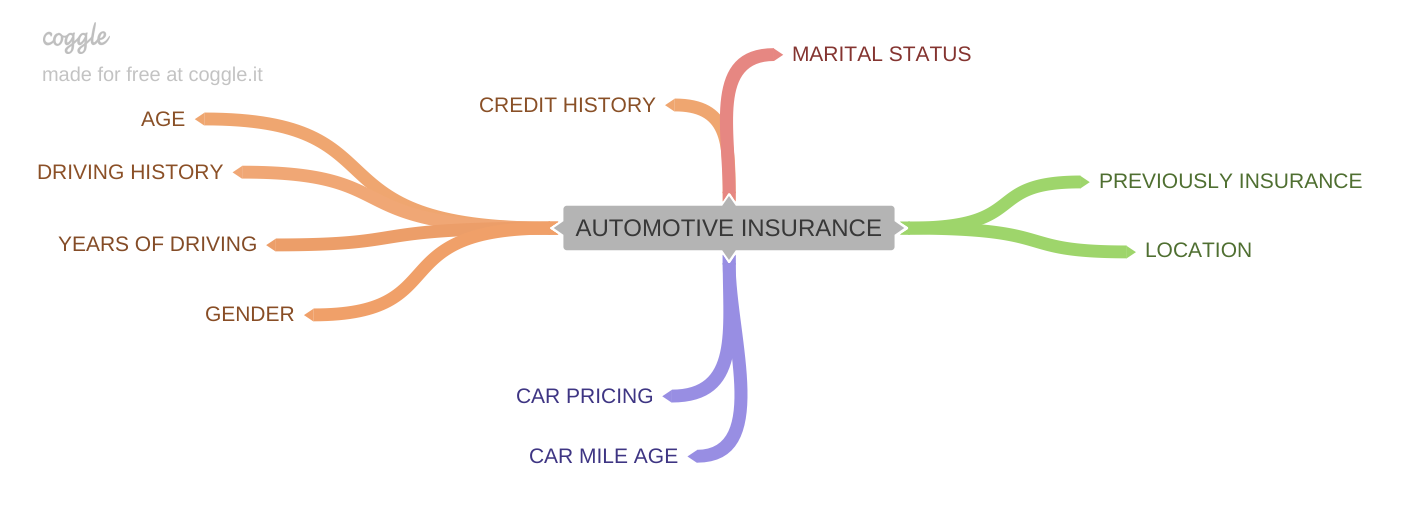

In [84]:
path = '../src/visualization/AUTOMOTIVE_INSURANCE.png'
Image(path)

## 4.2 Univariate Analysis

### Gender

In [88]:
Counter(df2['gender'])

Counter({'Male': 185331, 'Female': 157667})

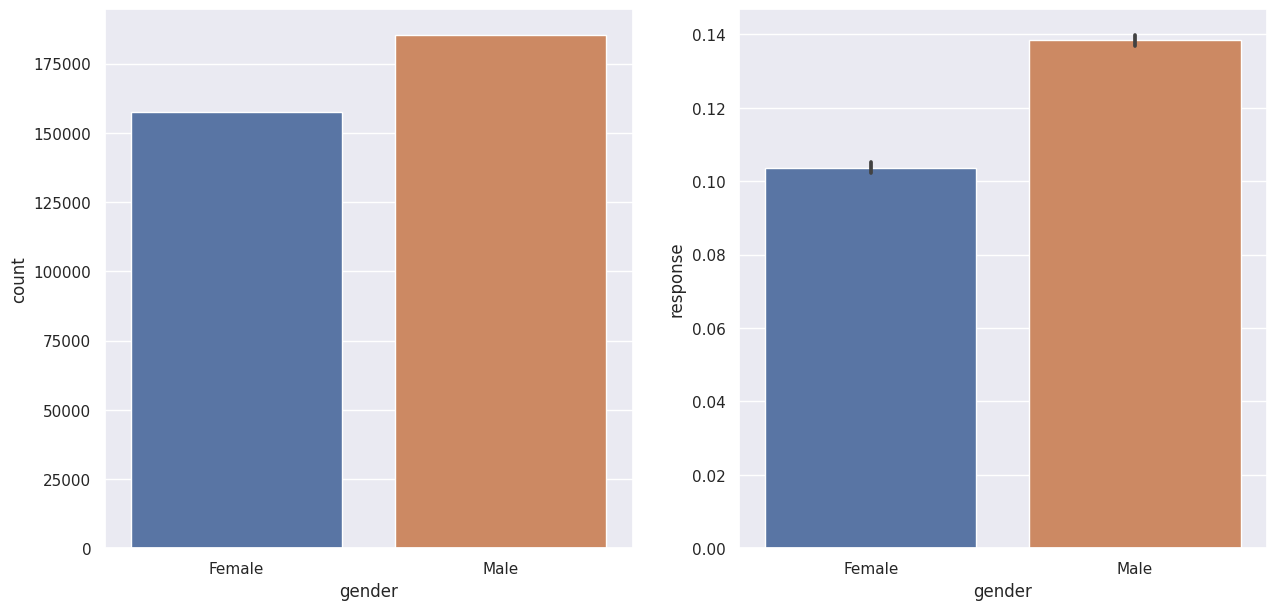

In [102]:
plt.subplot(1, 2, 1)
sns.countplot(x='gender', data=df2); # Count

plt.subplot(1, 2, 2)
sns.barplot(x='gender', y='response', data=df2); # Gender vs Response

In [154]:
# Annual premium by gender
df2[['annual_premium', 'gender']].groupby('gender').mean().reset_index()

,gender,annual_premium
0,Female,30485.948696
1,Male,30629.406494


### Age

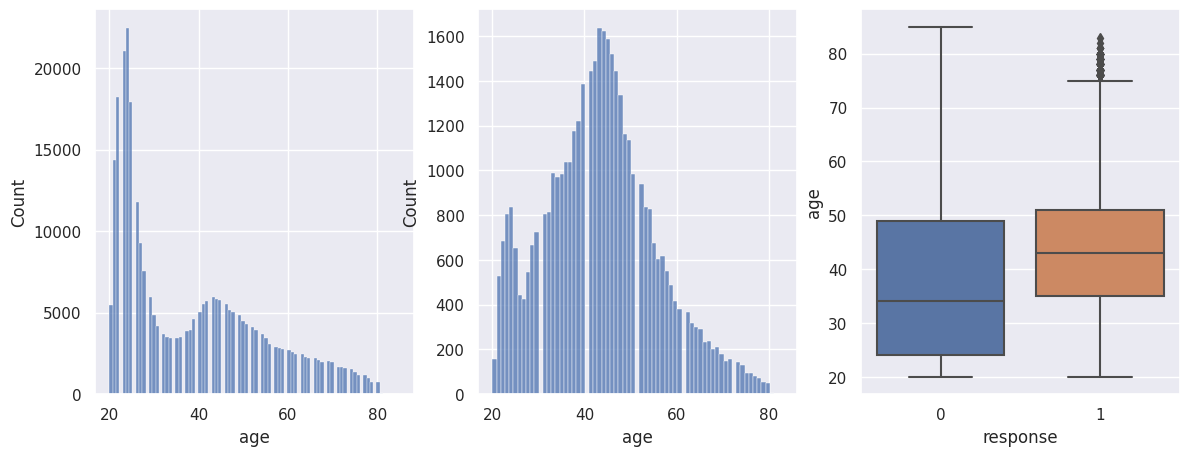

In [148]:
# response = 0 
plt.subplot(1, 3, 1)
aux0 = df2[df2['response'] == 0]
sns.histplot( aux0['age'] );

# response = 1
plt.subplot(1, 3, 2)
ax = df2[df2['response'] == 1]
sns.histplot(ax['age']);

# boxplot
plt.subplot(1, 3, 3)
sns.boxplot(x='response', y='age', data=df2);

### Driving License

In [157]:

df2[['driving_license', 'response']].groupby('driving_license').count().reset_index()

,driving_license,response
0,0,734
1,1,342264


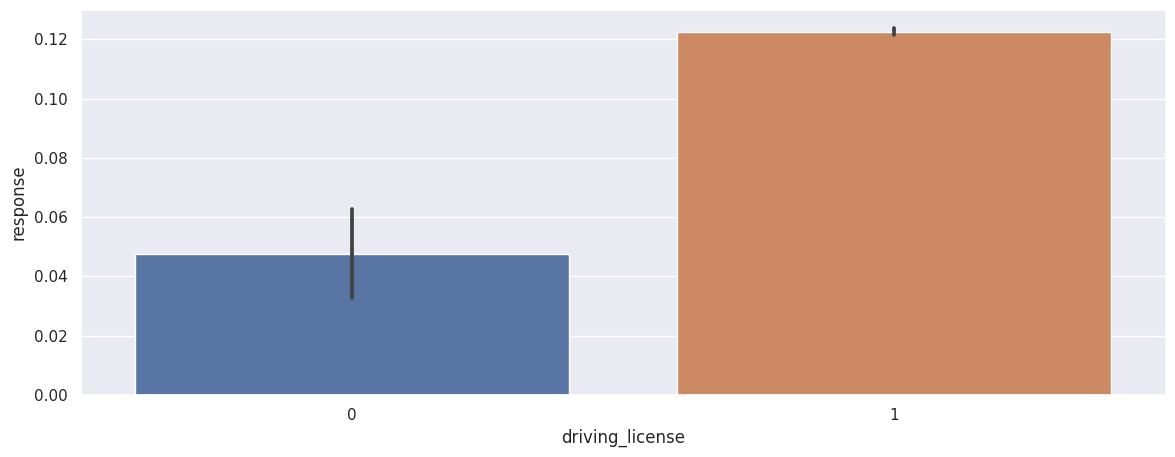

In [150]:
sns.barplot(x='driving_license', y='response', data=df2);

### Region Code

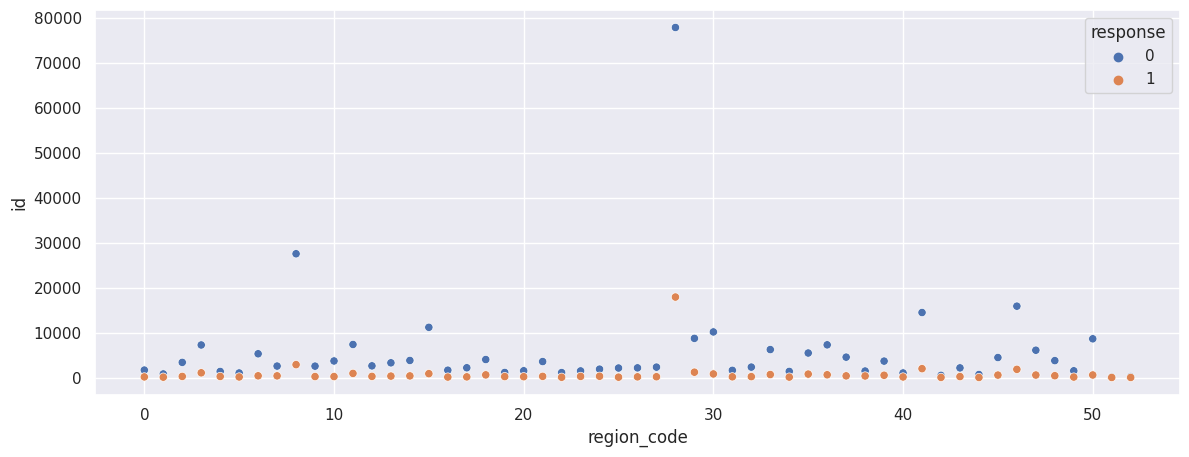

In [214]:
aux1 = df2[['region_code', 'response', 'id']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux1);

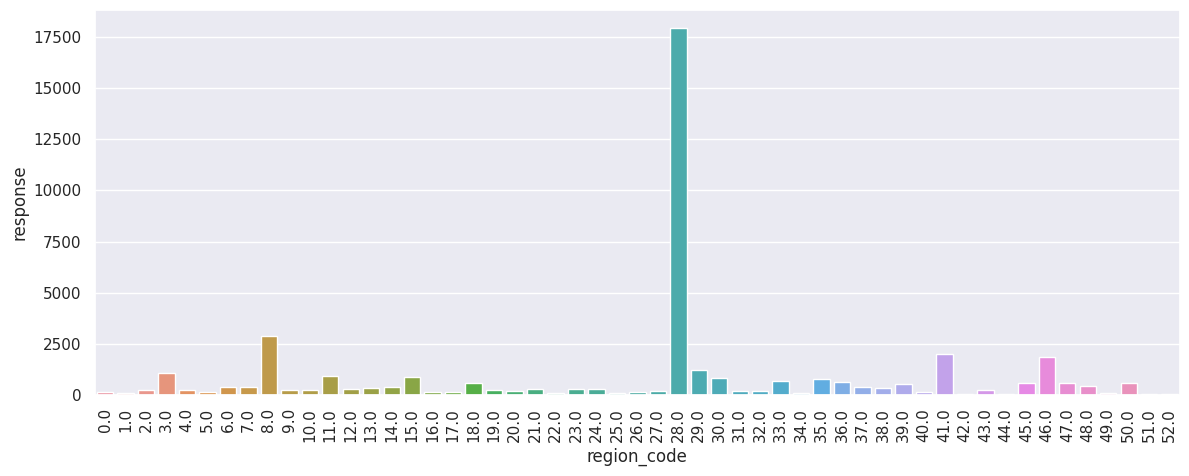

In [158]:
# Positive response per region code
aux2 = df1[df1['response'] == 1]
aux3 = aux2[['response', 'region_code']].groupby('region_code').count().reset_index()
sns.barplot(x='region_code', y='response', data=aux3);
plt.xticks(rotation=90);


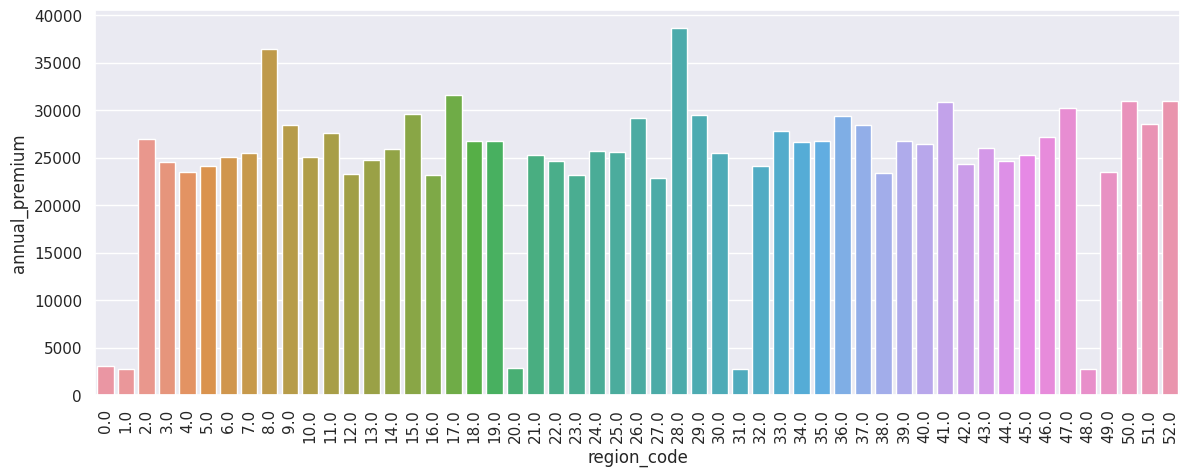

In [162]:
# Average Annual premium by region code
aux1 = df2[['region_code', 'annual_premium']].groupby('region_code').mean().reset_index()
sns.barplot(x='region_code', y='annual_premium', data=aux1);
plt.xticks(rotation=90);

In [207]:
# Annual premium >= mean region
aux2 = df2[ df2['annual_premium'] >= df2['mean_premium_by_code'] ]
count = Counter(aux2['response'])
one = (count[1]/(count[0] + count[1])) * 100
print('There are {:.2f}% of positive response'.format(one))

There are 11.93% of positive response


In [208]:
# Annual premium < mean region
aux3 = df2[ df2['annual_premium'] < df2['mean_premium_by_code'] ]
count1 = Counter(aux3['response'])
one = (count1[1]/(count1[0] + count1[1])) * 100
print('There are {:.2f}% of positive response'.format(one))


There are 12.62% of positive response


### Previously Insured

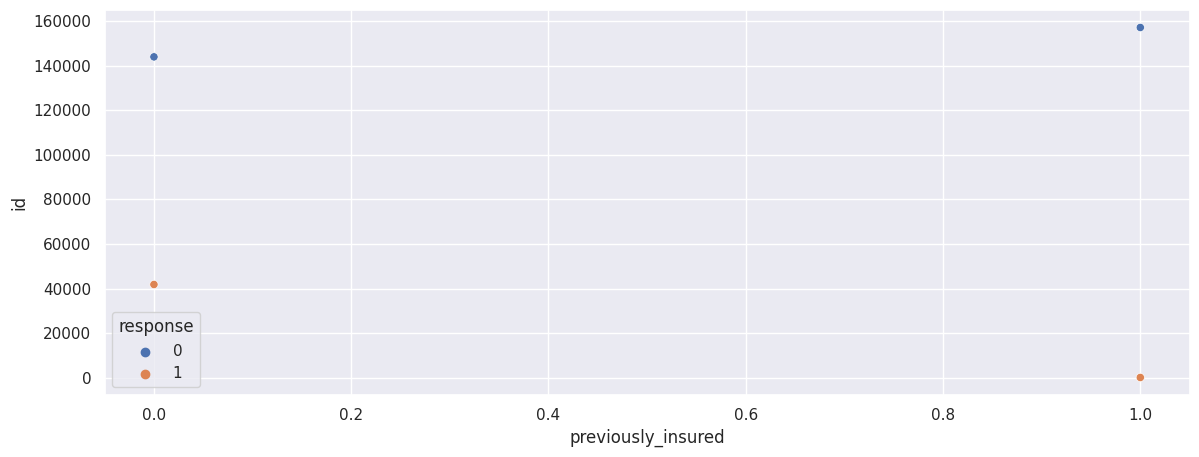

In [223]:
aux1 = df2[['id', 'response', 'previously_insured']].groupby(['previously_insured', 'response']).count().reset_index()
sns.scatterplot(x='previously_insured', y='id', hue='response', data=aux1);

In [225]:
pd.crosstab(df2['previously_insured'], df2['response']).apply( lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774749,0.225251
1,0.999110,0.000890


### Vahicle Age

In [236]:
Counter(df2['vehicle_age'])

Counter({'1-2': 180223, '>2': 148391, '<1': 14384})

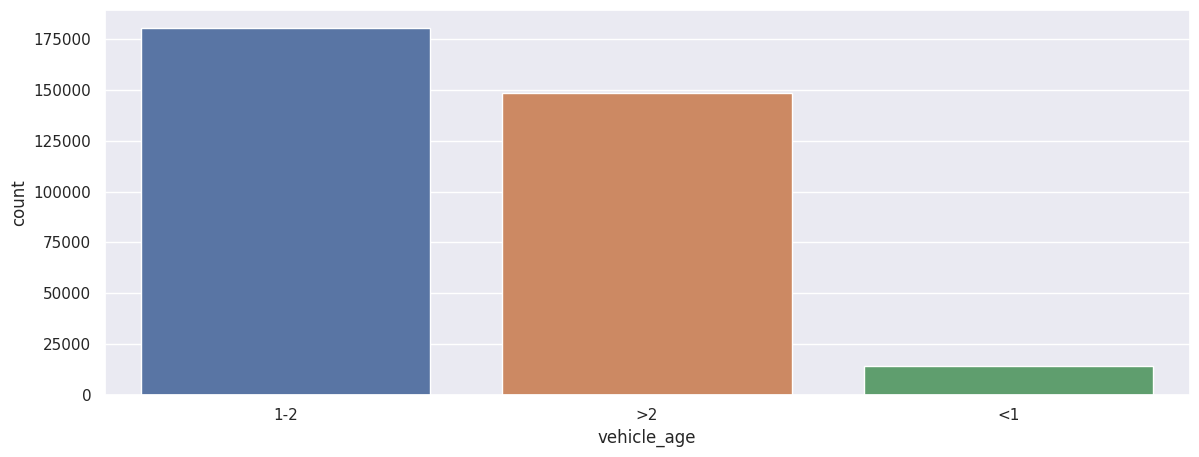

In [227]:
sns.countplot(x='vehicle_age', data=df2);

In [233]:
aux = df2[['id', 'response', 'vehicle_age']].groupby(['vehicle_age', 'response']).count().reset_index()
#sns.barplot(x='vehicle_age', y='id', hue='response', data=df2);
aux

,vehicle_age,response,id
0,1-2,0,148941
1,1-2,1,31282
2,<1,0,10191
3,<1,1,4193
4,>2,0,141883
5,>2,1,6508


In [234]:
fil = df2[df2['response'] == 1]
fil[['id', 'response', 'vehicle_age']].groupby(['vehicle_age', 'response']).count().reset_index()

,vehicle_age,response,id
0,1-2,1,31282
1,<1,1,4193
2,>2,1,6508


### Vehicle Damage

In [243]:
df2[['vehicle_damage', 'response']].groupby('response').count().reset_index()

,response,vehicle_damage
0,0,301015
1,1,41983


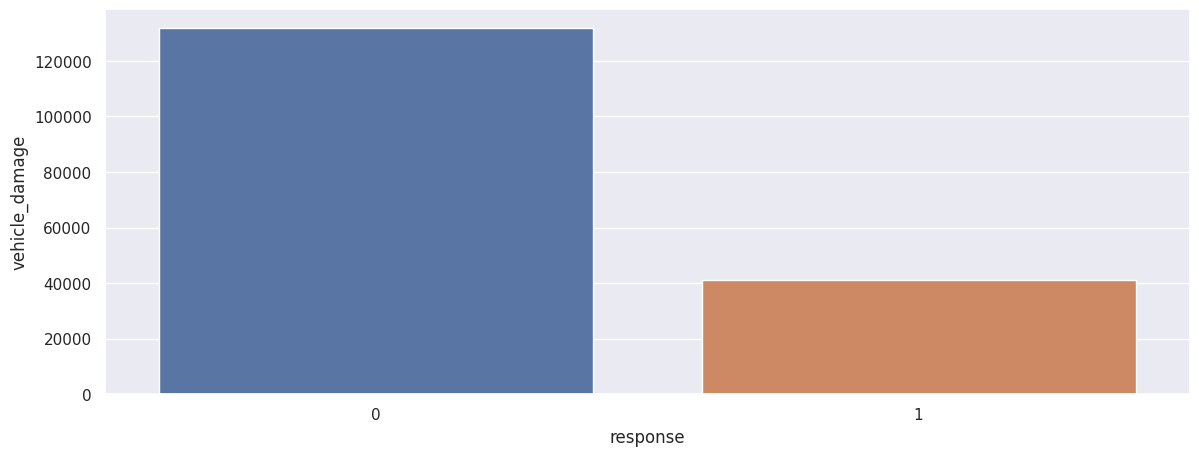

In [241]:
aux = df2[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='vehicle_damage', data=aux);

### Annual Premium

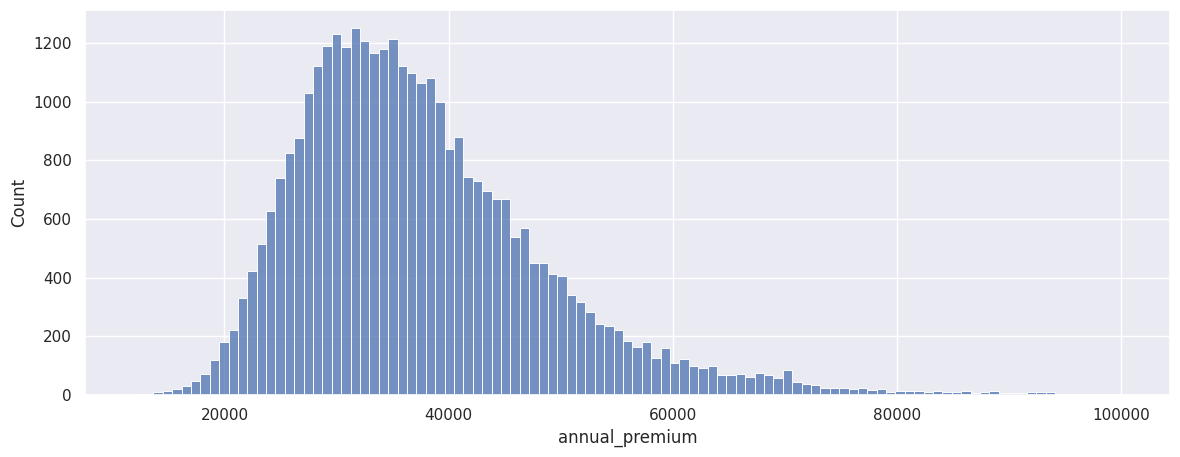

In [270]:
# Only positive answer
fil1 = df2[(df2['response'] == 1) & (df2['annual_premium'] > 10000) & (df2['annual_premium'] < 100000)]
sns.histplot(x='annual_premium', data=fil1);

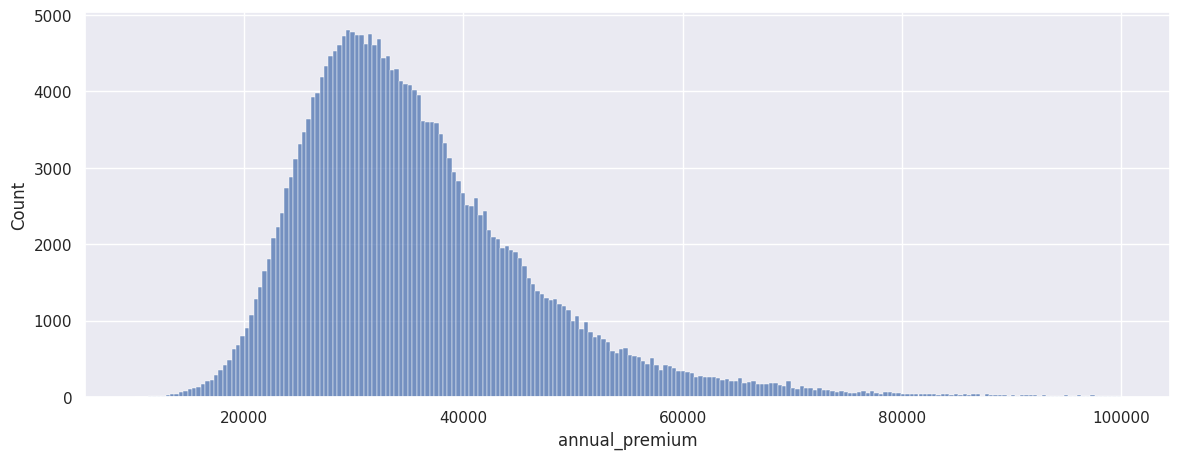

In [271]:
# Only negative asnwer
fil2 = df2[(df2['response'] == 0) & (df2['annual_premium'] > 10000) & (df2['annual_premium'] < 100000)]
sns.histplot(x='annual_premium', data=fil2);

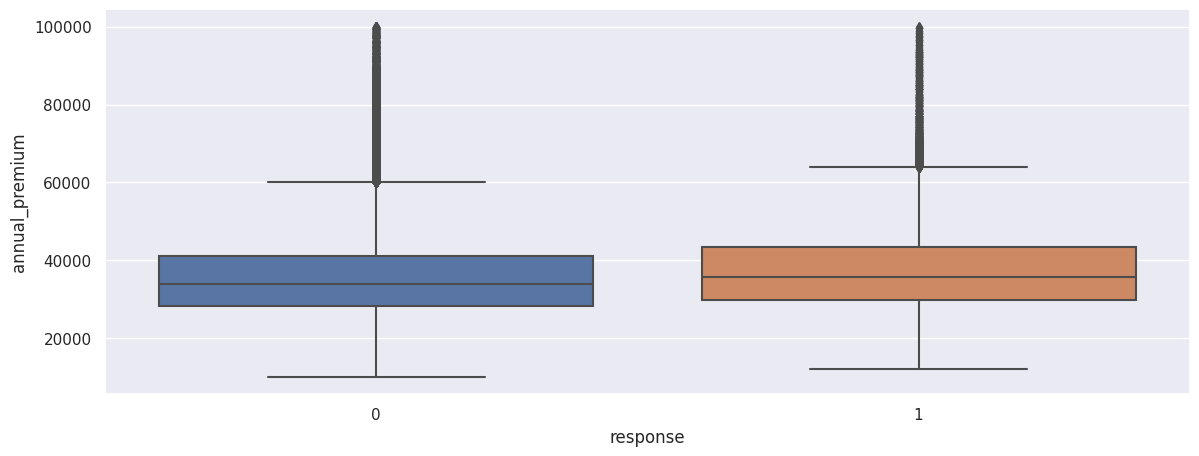

In [266]:
sns.boxplot(x='response', y='annual_premium', data=df3);

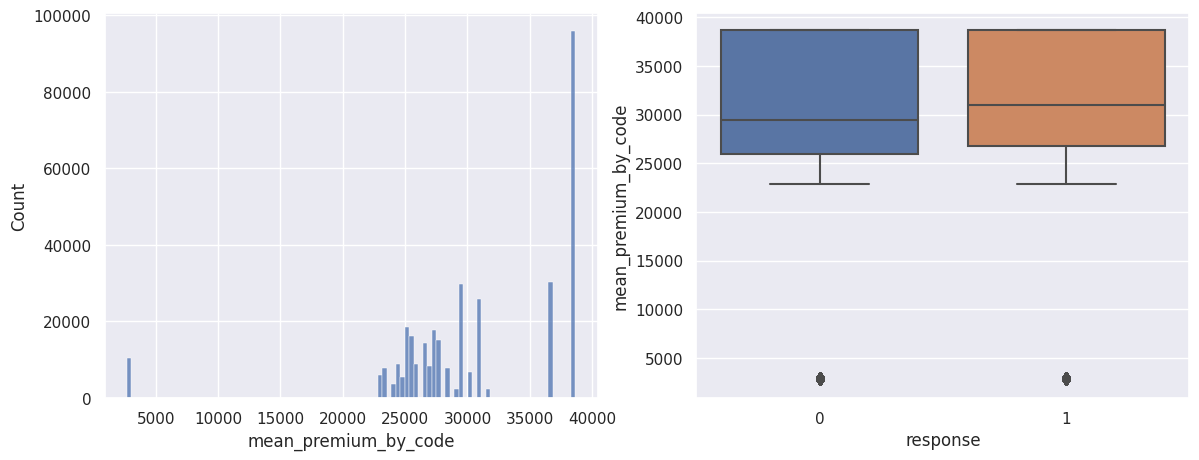

In [290]:
plt.subplot(1, 2, 1)
sns.histplot(x='mean_premium_by_code', data=df2);

plt.subplot(1, 2, 2)
sns.boxplot(x='response', y='mean_premium_by_code', data=df2);

### Policy Sales Channel

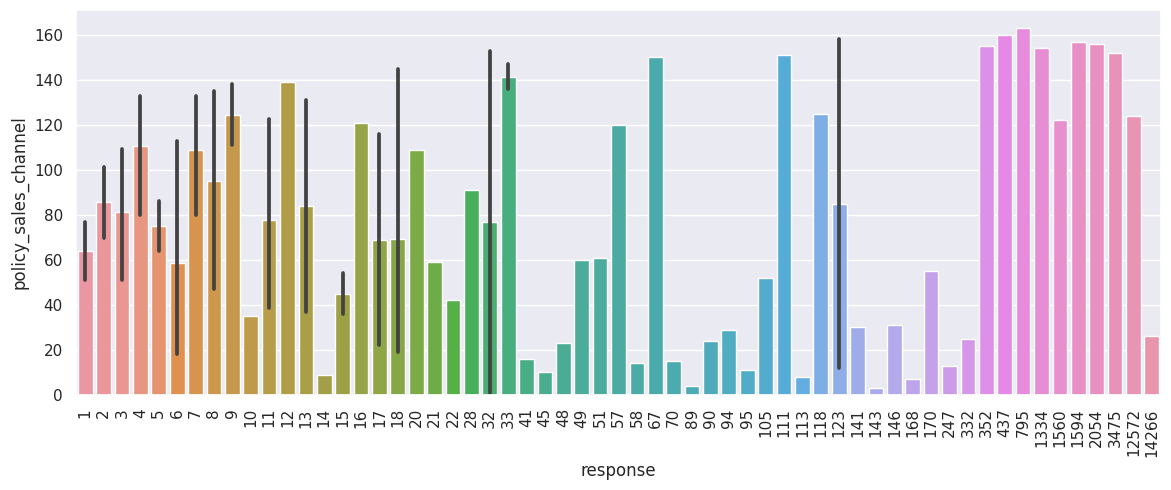

In [281]:
fil1 = df3[['response', 'policy_sales_channel']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=fil1);
plt.xticks(rotation=90);

### Vintage

<Axes: xlabel='vintage', ylabel='Count'>

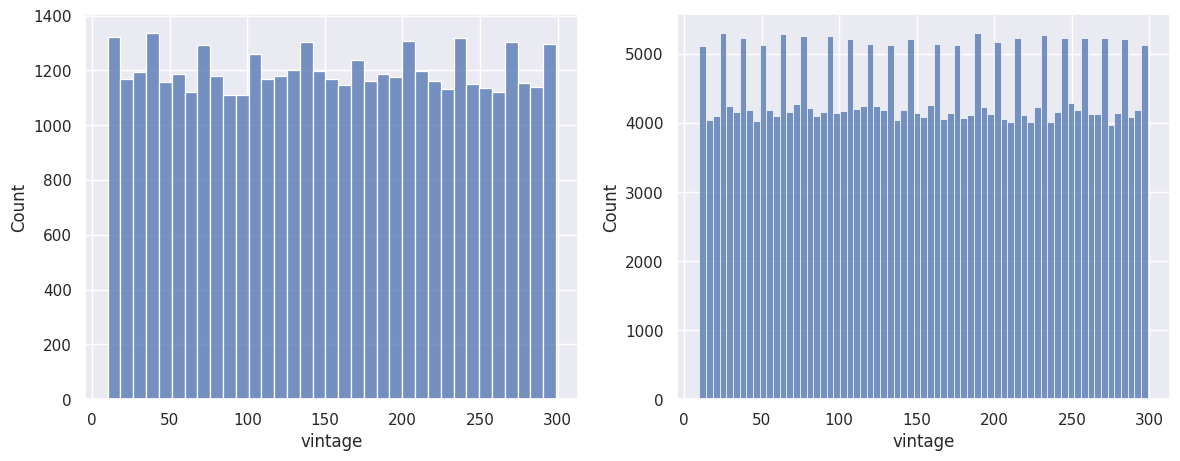

In [285]:
plt.subplot(1, 2, 1)
fil = df2[df2['response'] == 1 ]
sns.histplot(x='vintage', data=fil);

plt.subplot(1, 2, 2)
fil2 = df2[df2['response'] == 0]
sns.histplot(x='vintage', data=fil2)

# 5.0 Data Preparation

In [ ]:

4. Filtragem de Variáveis
5. EDA
   	5.1 Univariate
   	5.2 Biratiate (Hypothesis Validation)
6. Data Preparation
   	6.1 Rescaling
   	6.2 Encoding
   	6.3 Transformation
7. Feature Selection
   	7.1 Split Train & Validation
   	7.2 Feature Selection
   		- Boruta
		- Feature Importance
8. ML Modeling
   	8.1 Average Model
   	8.2 Test Models
   	8.3 Performance Comparation
   	8.4 Cross Validation
9. Fine Tuning
	9.1 Random Search
	9.2 Bayesian Search
10. Tradução e Interpretação do Erro
11. Modelo em Produção
